In [37]:
import pandas as pd
import pickle
from langchain_community.vectorstores import chroma as Chroma
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_community.document_loaders import DataFrameLoader
from langchain.indexes import SQLRecordManager, index
from langchain_core.documents import Document
import json
from Text_preprocessing import Text_preprocessing
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationChain, LLMChain, LLMRouterChain, MultiPromptChain, HypotheticalDocumentEmbedder, RetrievalQA
from langchain_core.prompts import PromptTemplate
import dotenv

In [8]:
##FSD_1777
dataPath = "/home/mbhatti/mnt/d/LLM-repo1/models/langchain_implementation/FSD1777_Oct23.json"
dateFrom = "2023-10-19T18:58:41+00:00" #2023-10-19T18:58:41Z for 200 tweets
dateTo = "2023-10-19 23:58:47+00:00"


In [9]:
"""Load relevant fields of flood tags api json response"""
def json_dataloader(dataPath = dataPath, dateFrom = dateFrom, dateTo = dateTo):
    # Load json and extract relevant records in pandas df
    with open(dataPath, 'r') as json_file:
        response_dict = json.load(json_file)

    # Convert to pandas df    
    pd.set_option('display.max_colwidth', None)
    df = pd.DataFrame(response_dict)
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop(columns=['id','tag_class', 'source', 'lang', 'urls','locations'])

    #Get data between thresholds
    threshold_datetime_lower = pd.to_datetime(dateFrom)
    threshold_datetime_upper = pd.to_datetime(dateTo)
    df = df[df['date'] >= threshold_datetime_lower]
    df = df[df['date'] <= threshold_datetime_upper]

    #Pre-process
    preprocess = Text_preprocessing(df)
    df = preprocess.preprocess()
    #Covert date to string
    df['date'] = df['date'].astype(str)
    return df

def bgeEmbeddings():
    model_name = "BAAI/bge-large-en-v1.5"
    model_kwargs = {'device': 'cuda'}
    encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
    model = HuggingFaceBgeEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )
    return model

def hydeEmbedder(embeddingsModel):

    model = ChatOpenAI()
    prompt_template  = """You are a smart twitter bot. Make up 2 tweets as answers to the users question related to flooding events. Only return the dummy tweets.<<SYS>>
    Question: {question}"""
    prompt = PromptTemplate(input_variables=["question"], template= prompt_template)
    llm_chain_hyde  = LLMChain(llm = model, prompt=prompt)

    embeddings = HypotheticalDocumentEmbedder(llm_chain=llm_chain_hyde,
                                                base_embeddings=embeddingsModel,
                                                verbose=True)
    return embeddings


def data_embedding(data : list, eModel = "bge-large-en-v1.5", rType = "Query"):
    """Vectorize the data using OpenAI embeddings and store in Chroma db"""

    embeddings = bgeEmbeddings()
    
    if (rType == "Hyde"):
        embeddings = hydeEmbedder(embeddings)

    documents = []
    loader = DataFrameLoader(data, page_content_column="text")
    documents.extend(loader.load())

    #Create a vector store
    db = Chroma.Chroma.from_documents(documents,embeddings)

    return db

In [38]:

dotenv.load_dotenv()
embeddings = bgeEmbeddings()
embeddings = hydeEmbedder(embeddings)
data = json_dataloader()
documents = []
loader = DataFrameLoader(data, page_content_column="text")
documents.extend(loader.load())
#Create a vector store
# db = Chroma.Chroma("Langchain collection",embeddings)
db = Chroma.Chroma.from_documents(documents,embeddings)

In [39]:
retriever = db.as_retriever(search_kwargs={"k": 7})

In [40]:
import umap
import numpy as np
from tqdm import tqdm
docs = data.text.tolist()
vectors = embeddings.embed_documents(docs)
umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

/home/mbhatti/miniconda3/envs/llama/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [41]:
def umap_embed(vectors, umap_transformer):
    umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
    return umap_embeddings

In [42]:

global_embeddings = umap_embed(vectors, umap_transformer)

100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


In [43]:
global_embeddings

array([[ 1.75623202e+00,  5.52898216e+00],
       [ 7.72829723e+00,  3.00102562e-01],
       [ 7.02126074e+00, -1.08364999e+00],
       [ 9.09053516e+00,  2.41304469e+00],
       [ 6.51023817e+00,  2.78219628e+00],
       [ 5.53438568e+00,  2.14747667e-01],
       [ 5.94207668e+00, -1.57304645e-01],
       [ 3.89509583e+00,  9.31167781e-01],
       [ 5.27059937e+00,  3.55996668e-01],
       [ 9.33876991e+00,  1.24693084e+00],
       [ 1.09657097e+00,  5.03150463e+00],
       [ 1.09657097e+00,  5.03150463e+00],
       [ 8.78105736e+00, -1.29177943e-01],
       [ 8.23951435e+00, -6.84069172e-02],
       [ 6.11398077e+00, -5.00663519e-01],
       [ 7.67764521e+00,  2.36316061e+00],
       [ 2.77765322e+00, -5.30046523e-01],
       [ 7.12062883e+00,  3.36534452e+00],
       [ 3.82099247e+00, -7.99102545e-01],
       [ 7.84689379e+00,  2.24708605e+00],
       [ 6.05871868e+00, -1.58214062e-01],
       [ 1.70287693e+00,  5.08224869e+00],
       [ 5.50630474e+00,  1.41156081e-03],
       [ 5.

(0.6787068367004394, 9.871717739105225, -1.8901643931865693, 6.646573203802109)

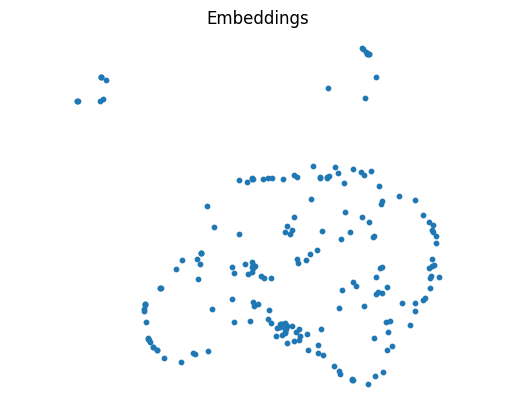

In [44]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

In [45]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    # print(docs)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()

100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


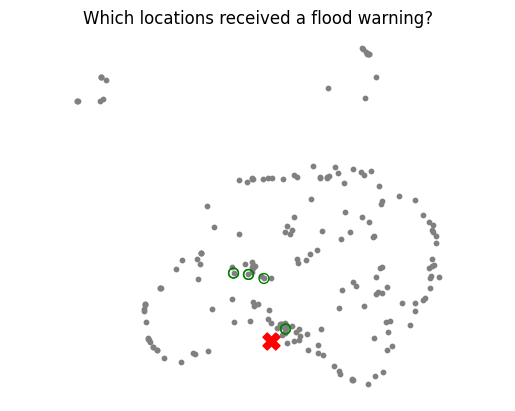

In [48]:
calc_global_embeddings("Which locations received a flood warning?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)
